In [ ]:
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import numpy as np
import os

# sc.settings.verbosity = 2

## Preprocess

In [ ]:
data_dir = "./data/raw/"
h5_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".h5")]

13

### Filter

In [5]:
samples = {}

for h5_file in h5_files:
    basename = os.path.basename(h5_file)
    sample_id = basename.split(".")[0].split("_")[-1]
    samples[sample_id] = h5_file

In [ ]:
for ix, (sample_id, filename) in enumerate(samples.items()):
    print(f"Processing file {ix + 1}/{len(samples)}: {sample_id}")

    sample_adata = sc.read_10x_h5(filename)
    sample_adata.var_names_make_unique()

    # filter for genes
    sc.pp.filter_cells(sample_adata, min_genes=200)
    sc.pp.filter_cells(sample_adata, max_genes=7000)

    # filter for more than 25% mitochondrial genes
    sample_adata.var["mt"] = sample_adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(sample_adata, qc_vars="mt", inplace=True, log1p=True)
    sample_adata = sample_adata[sample_adata.obs.pct_counts_mt < 25, :]
    
    # store the filtered data
    filtered_dir = "./data/filtered/"
    basename = os.path.basename(filename)
    basename = os.path.splitext(basename)[0]
    filtered_file = os.path.join(filtered_dir, f"{basename}_filtered.h5ad")
    sample_adata.write_h5ad(filtered_file)

### Combine

In [42]:
filtered_data_dir = "./data/filtered"
filtered_h5_files = [os.path.join(filtered_data_dir, f) for f in os.listdir(filtered_data_dir) if f.endswith(".h5ad")]

In [43]:
samples = {}

for h5_file in filtered_h5_files:
    basename = os.path.basename(h5_file)
    sample_id = basename.split(".")[0].split("_")[-1]
    samples[sample_id] = h5_file

In [ ]:
adatas = {}

for ix, (sampled_id, filename) in enumerate(samples.items()):

    sample_adata = sc.read_h5ad(filename)
    sample_adata.var_names_make_unique()

    adatas[sampled_id] = sample_adata

# concatenate using outer to keep all genes and samples
adata = ad.concat(adatas, join="outer", label="sample")

combined_file = os.path.join(filtered_data_dir, "combined_filtered.h5ad")
adata.write_h5ad(combined_file)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Clean

In [2]:
adata = sc.read_h5ad('/home/enno/code/scAnalysis/data/merged/combined_filtered.h5ad')
adata.obs_names_make_unique()

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Feature Selection

In [4]:
# identify HVGs and subset
# https://discourse.scverse.org/t/how-to-handle-data-lognormalization-when-using-highly-variable-genes-with-flavor-seurat-v3/1076
sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=True, flavor="seurat_v3", subset=True, batch_key="sample")

### Regress out counts, percent mitochondrial and cell cycle 

In [ ]:
# saving count data
adata.layers["counts"] = adata.X.copy()

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [8]:
# cell cycle regression
# https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

       'DTL', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1',
       'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'RAD51',
       'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1',
       'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'],
      dtype='object')
       'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'CDCA2', 'PSRC1', 'LBR',
       'CKAP5', 'CTCF', 'G2E3', 'GAS2L3', 'CBX5'],
      dtype='object')


In [9]:
# store as h5ad
adata.write_h5ad('./data/merged/cleaned_wo_regress_out_mt.h5ad')

## Cluster Analysis

In [3]:
adata = sc.read_h5ad('data/merged/cleaned.h5ad')  # cleaned_wo_regress_out_mt.h5ad

### PCA

In [ ]:
sc.tl.pca(adata, n_comps=50)

[<Axes: title={'center': 'phase'}, xlabel='PC1', ylabel='PC2'>,
 <Axes: title={'center': 'sample'}, xlabel='PC1', ylabel='PC2'>]

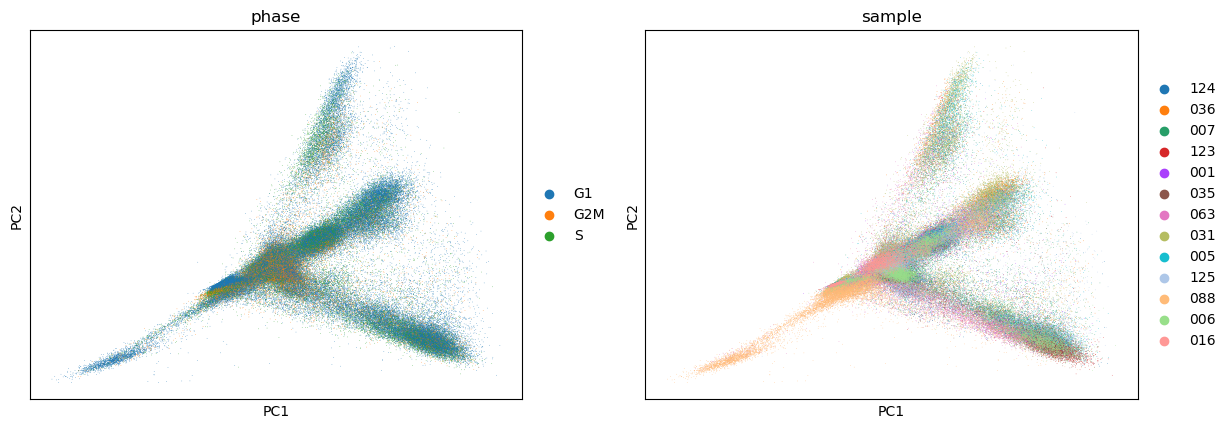

In [ ]:
sc.pl.pca(adata, color=['phase', 'sample'], use_raw=False, show=False)

### UMAP

In [ ]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)
sc.tl.umap(adata)

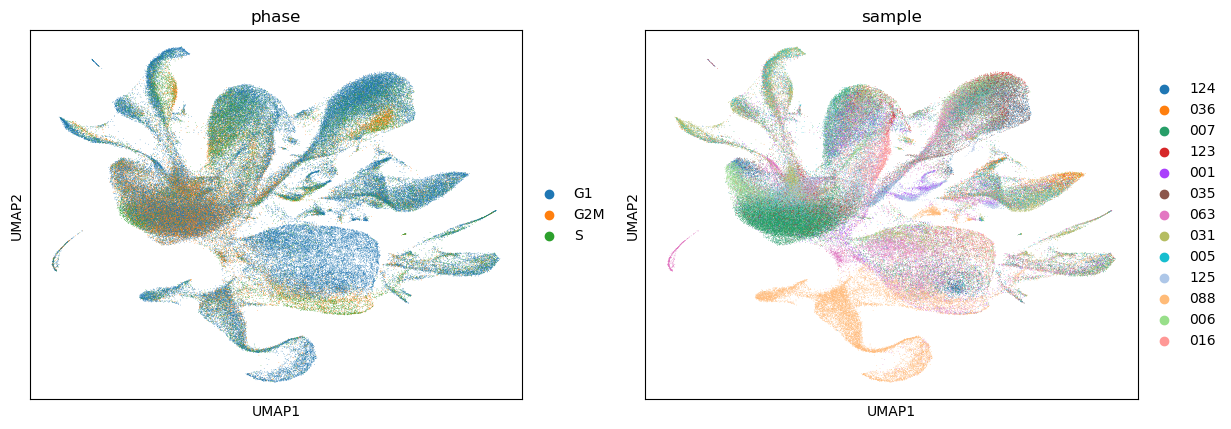

In [8]:
sc.pl.umap(adata, color=['phase', 'sample'], use_raw=False)

### Clustering

In [9]:
# clustering
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=15)
sc.tl.leiden(adata, flavor="igraph", resolution=0.3)

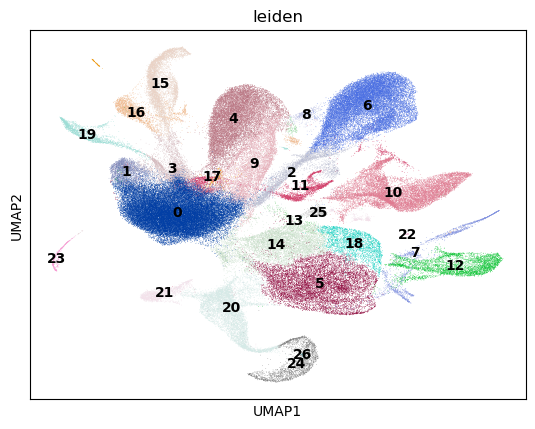

In [10]:
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

### Marker Gene Expression

In [ ]:
genes = [
    "PECAM1", "KDR", "PRRX1", "GATA4", "HAND2", "HNF4A", 
    "SPINK2", "AZU1", "FCGR1A", "CD163", "HBA2", "HBB", 
    "MITF", "PAX2", "NR5A1", "SOX10", "PLP1", "FOXD3", 
    "ELAVL3", "ELAVL4", "PHOX2B", "TH", "STMN2"
]

for gene in genes:
    is_in_data = gene in adata.var_names

    if not is_in_data:
        print(f"{gene} not in data")
        continue

GATA4 not in data
HNF4A not in data
FCGR1A not in data
ELAVL3 not in data


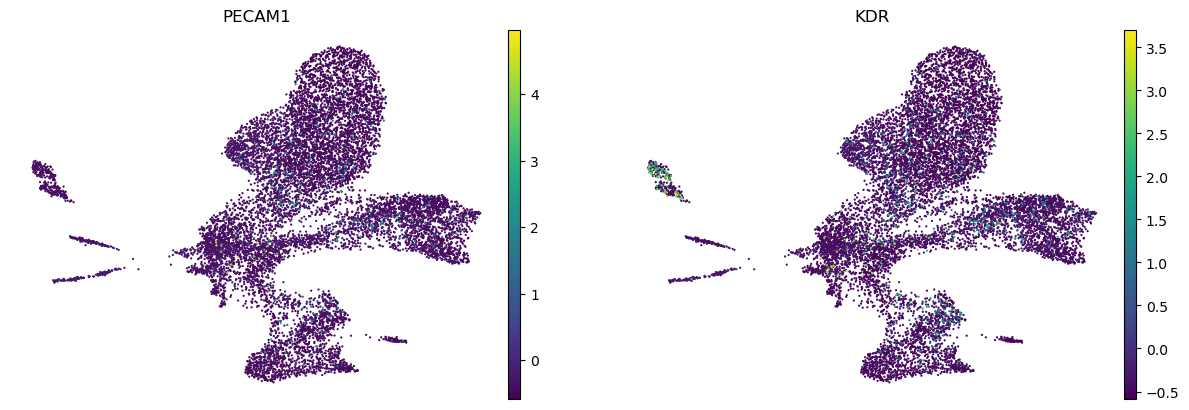

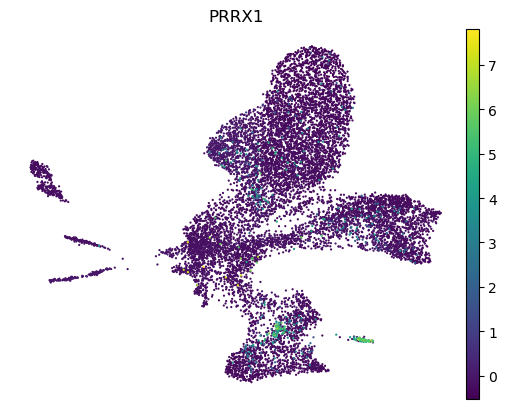

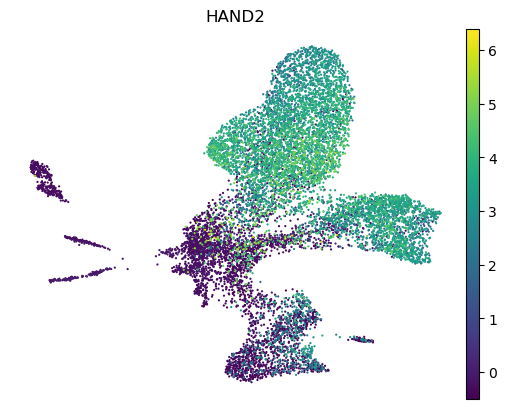

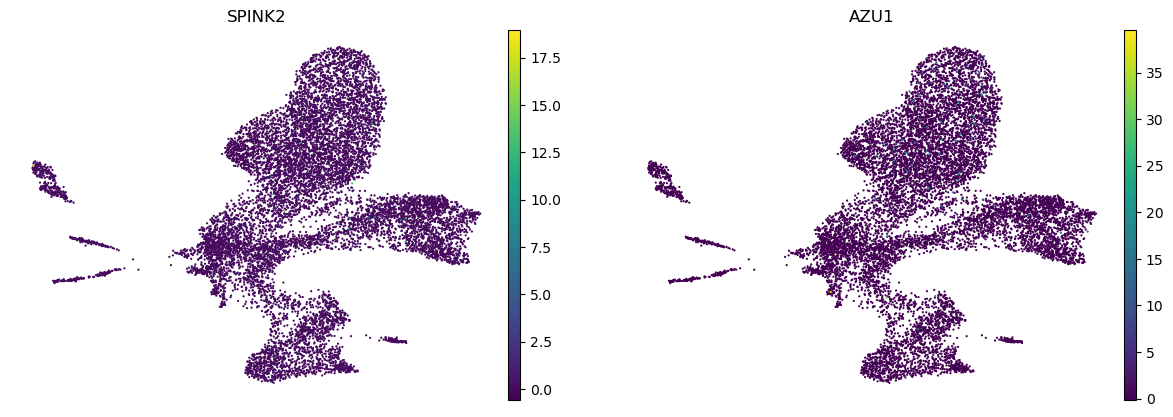

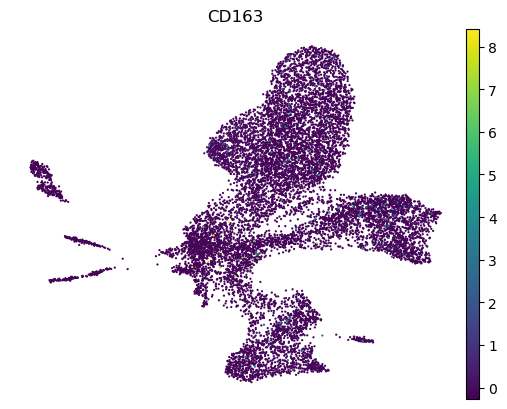

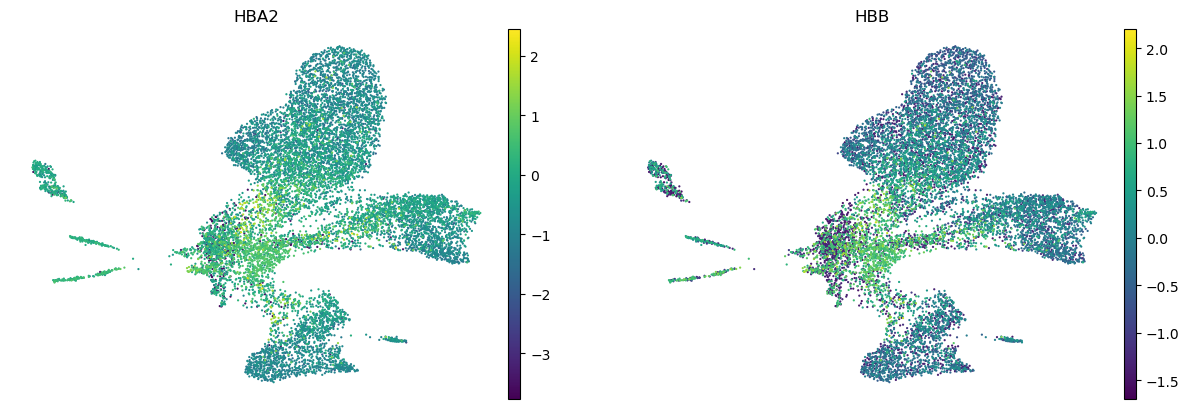

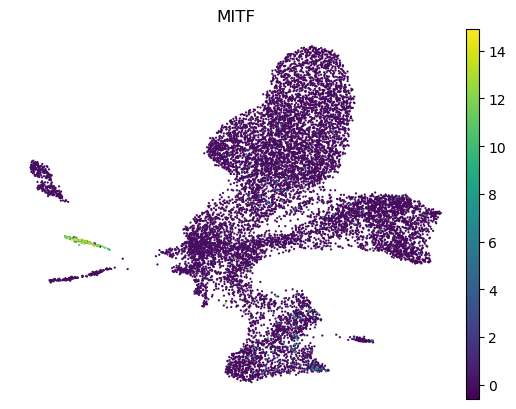

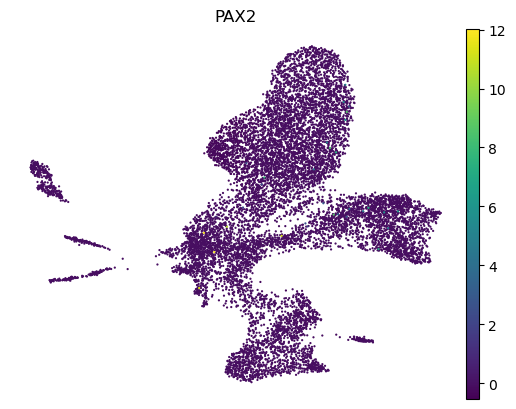

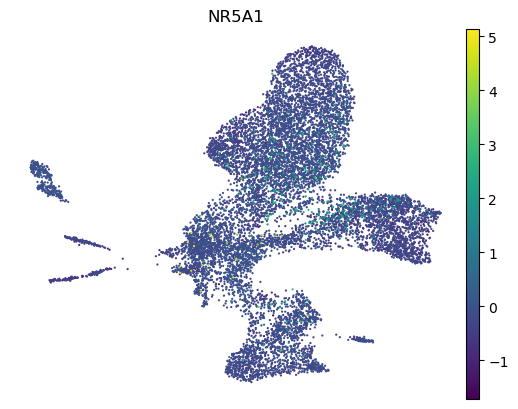

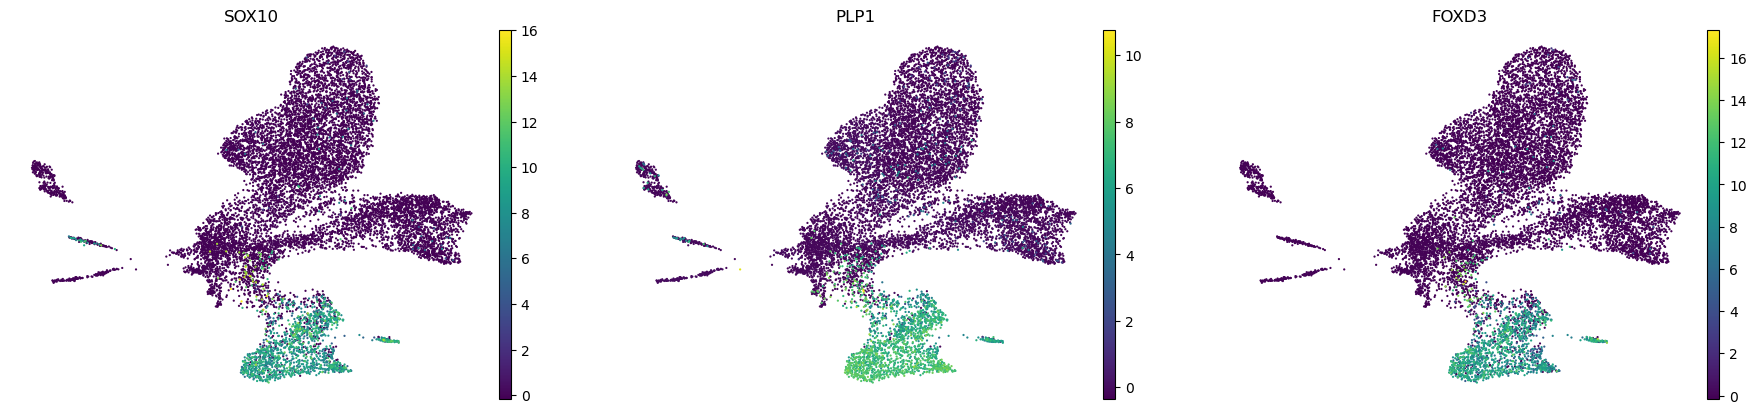

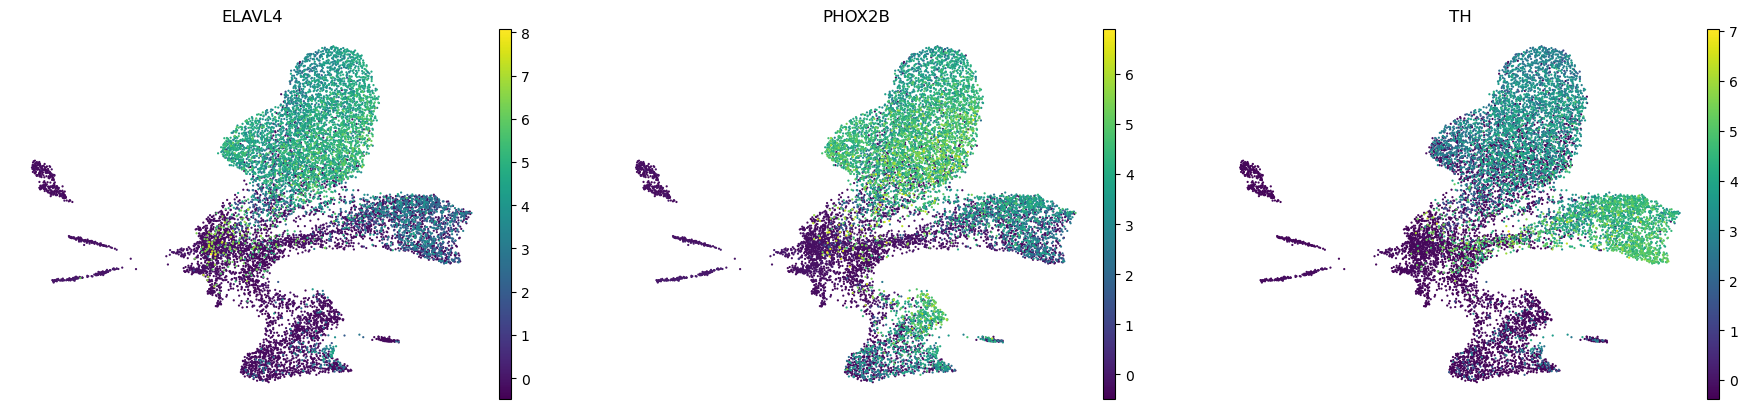

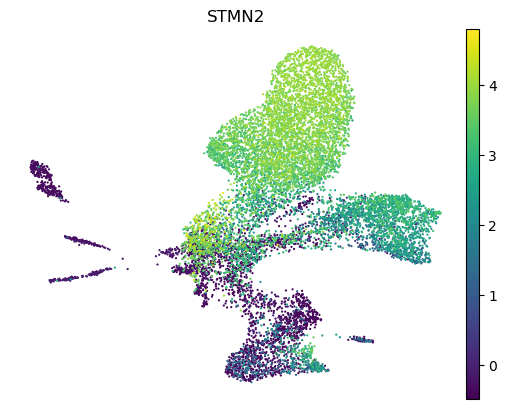

In [ ]:
# UMAP with genes: PECAM1, KDR
sc.pl.umap(adata, color=['PECAM1', 'KDR'], use_raw=False, frameon=False)

# UMAP with genes: PRRX1
sc.pl.umap(adata, color=['PRRX1'], use_raw=False, frameon=False)

# UMAP with genes: GATA4, HAND2
sc.pl.umap(adata, color=['HAND2'], use_raw=False, frameon=False)

# UMAP with genes: HNF4A
# sc.pl.umap(adata, color=['HNF4A'], use_raw=False, frameon=False)

# UMAP with genes: SPINK2, AZU1
sc.pl.umap(adata, color=['SPINK2', 'AZU1'], use_raw=False, frameon=False)

# UMAP with genes: FCGR1A, CD163
sc.pl.umap(adata, color=['CD163'], use_raw=False, frameon=False)

# UMAP with genes: HBA2, HBB
sc.pl.umap(adata, color=['HBA2', 'HBB'], use_raw=False, frameon=False)

# UMAP with genes: MITF
sc.pl.umap(adata, color=['MITF'], use_raw=False, frameon=False)

# UMAP with genes: PAX2
sc.pl.umap(adata, color=['PAX2'], use_raw=False, frameon=False)

# UMAP with genes: NR5A1
sc.pl.umap(adata, color=['NR5A1'], use_raw=False, frameon=False)

# UMAP with genes: SOX10, PLP1, FOXD3
sc.pl.umap(adata, color=['SOX10', 'PLP1', 'FOXD3'], use_raw=False, frameon=False)

# UMAP with genes: ELAVL3, ELAVL4, PHOX2B, TH
sc.pl.umap(adata, color=['ELAVL4', 'PHOX2B','TH'], use_raw=False, frameon=False)

# UMAP with genes: STMN2
sc.pl.umap(adata, color=['STMN2'], use_raw=False, frameon=False)

### Differentially Expressed Genes

In [44]:
# https://github.com/scverse/scverse-tutorials/blob/main/docs/notebooks/basic-scrna-tutorial.ipynb

In [18]:
# top 5 differential expressed genes per cluster
sc.tl.rank_genes_groups(adata, 'leiden')

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [35]:
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1.5)

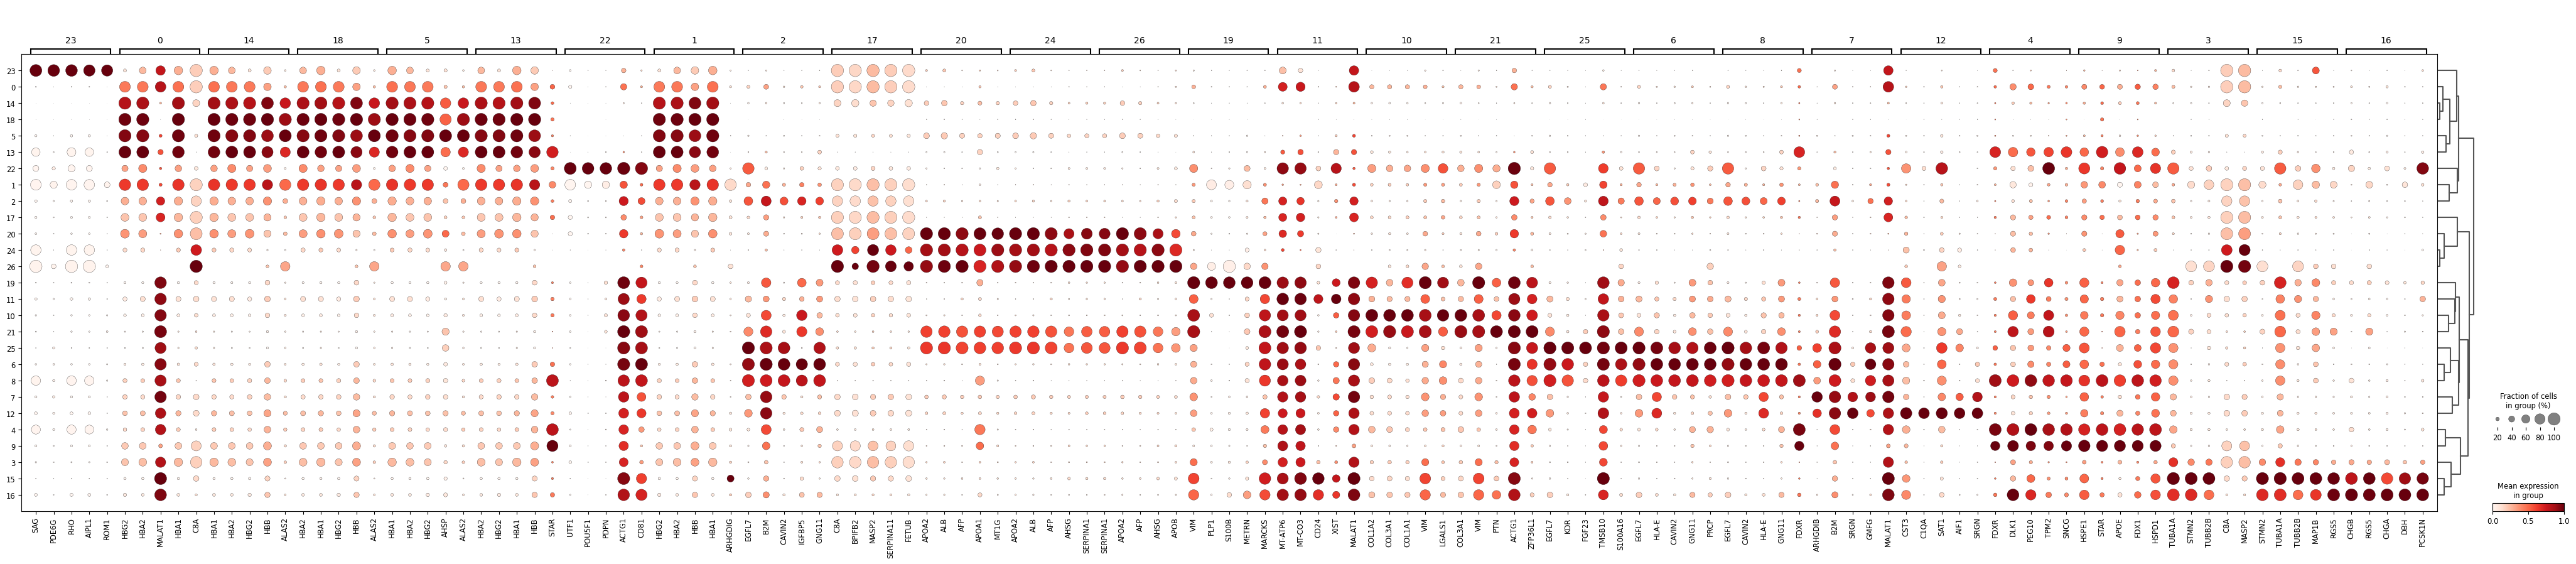

In [36]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

## Re-cluster

In [13]:
# confine analysis on clusters 15, 16, 19
adata = adata[adata.obs['leiden'].isin(['3', '15', '16', '19'])]

In [ ]:
# remove sample id 036 since it is an extra-adrenal sample
adata = adata[adata.obs['sample'] != '036']
adata.shape

(11766, 2000)

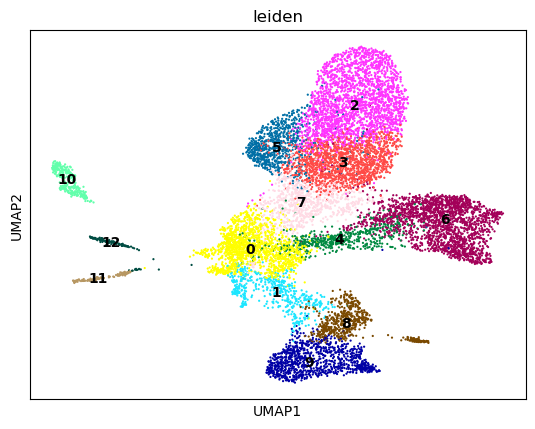

In [ ]:
# cluster
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=15)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.3)
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

In [ ]:
# remove 11 12 13 since they are disconnected
adata = adata[~adata.obs['leiden'].isin(['10', '11', '12'])]

In [31]:
# re-run PCA, neighbors, UMAP
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=200, n_pcs=15)
sc.tl.umap(adata)

/home/enno/anaconda3/envs/kameneva/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


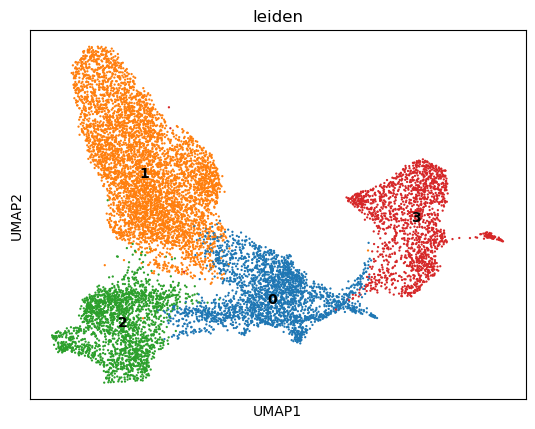

In [ ]:
# re-run Leiden and plot
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)
sc.pl.umap(adata, color='leiden', use_raw=False, legend_loc='on data', legend_fontsize=10)

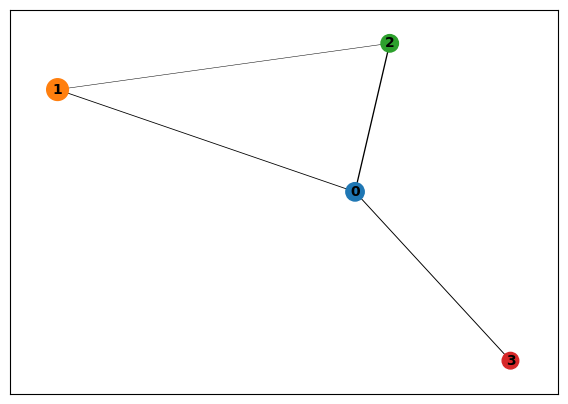

In [ ]:
# trajectory analysis
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, threshold=0.03, show=True)

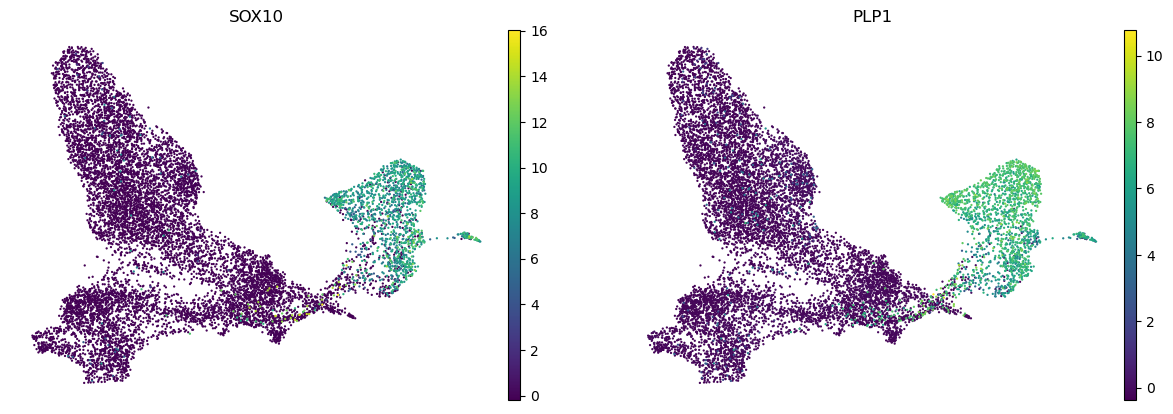

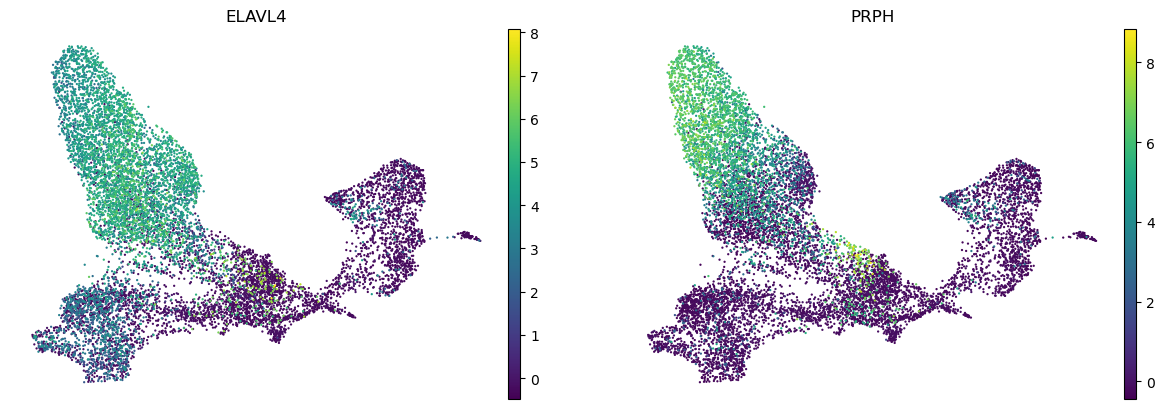

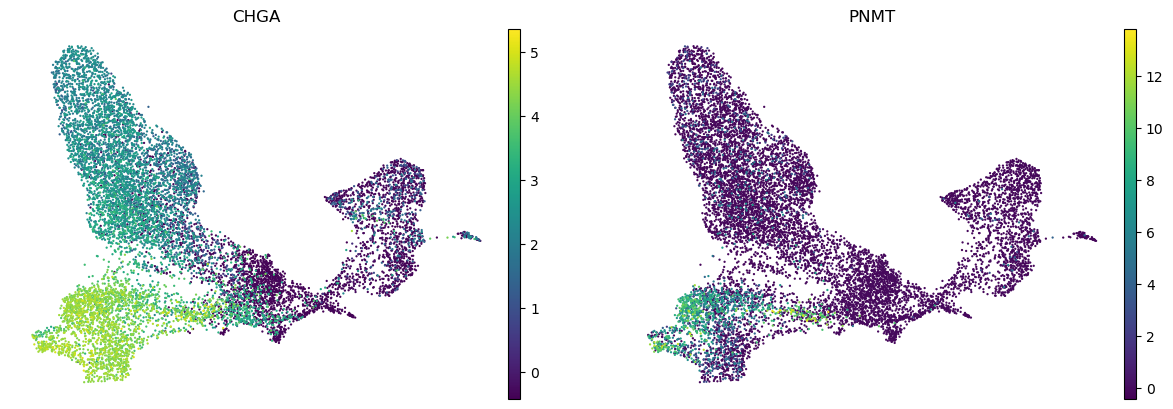

In [ ]:
# SCPs
sc.pl.umap(adata, color=['SOX10', 'PLP1'], use_raw=False, frameon=False)  # 'FOXD3'

# Symphatoblasts
sc.pl.umap(adata, color=['ELAVL4', 'PRPH'], use_raw=False, frameon=False) #  'ISL1'

# Chromaffin cells
sc.pl.umap(adata, color=['CHGA', 'PNMT'], use_raw=False, frameon=False)  # STMN2

# Cell cycle genes
# sc.pl.umap(adata, color=['MKI67', 'TOP2A', 'TUBB4B'], use_raw=False, frameon=False)

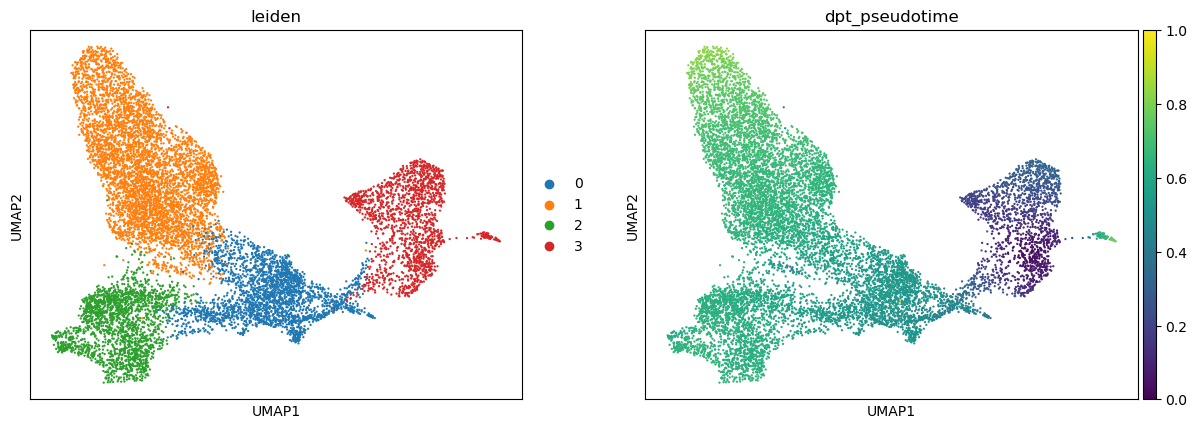

In [ ]:
# https://nbisweden.github.io/workshop-scRNAseq/labs/scanpy/scanpy_07_trajectory.html#gene-changes

# Choose a root cell or cluster
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden'] == '3')[0]

# Compute diffusion pseudotime
sc.tl.dpt(adata)

# Plot pseudotime
sc.pl.umap(adata, color=['leiden', 'dpt_pseudotime'], show=True)


In [23]:
# Define paths

paths = [('P1', ['3', '0', '1']),
         ('P2', ['3', '0', '2']),
         ('P3', ['3', '0', '1', '2']),
         ('P4', ['3', '0', '2', '1']),
         ]

adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [ ]:
gene_names = ['SOX10', 'PLP1', 'FOXD3', 'ELAVL4', 'PRPH', 'ISL1', 'CHGA', 'PNMT', 'STMN2']

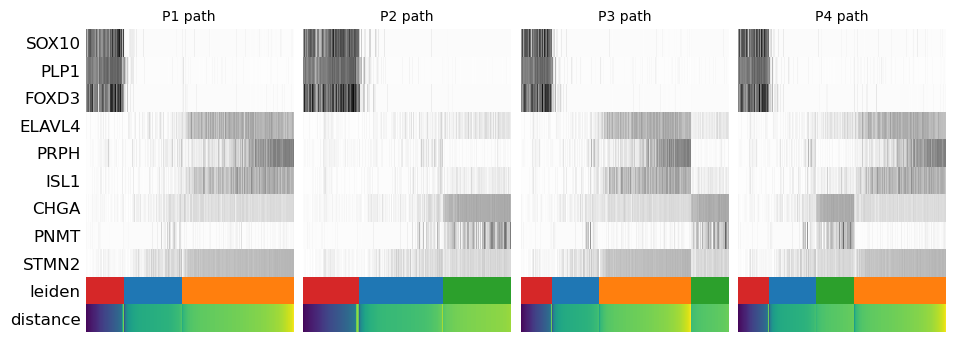

In [40]:
_, axs = plt.subplots(ncols=4, figsize=(10, 4), gridspec_kw={
                     'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(
        adata=adata, 
        nodes=path, 
        keys=gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=10,
        annotations=['distance'],
        show_yticks=True if ipath == 0 else False,
        show_colorbar=False,
        color_map='Greys',
        # groups_key='annot',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        use_raw=False,
        show=False)

plt.show()